<a href="https://colab.research.google.com/github/mkane968/Text-Mining-with-Student-Papers/blob/main/notebooks/Text_Mining_Student_Papers_12_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Text Mining Student Papers: A Computational Exploration


## 1. Install Packages

In [1]:
#Mount Google Drive
from google.colab import drive
from google.colab import files

#Install glob
import glob 

#Install pandas
import pandas as pd

#Install numpy
import numpy as np

#Imports the Natural Language Toolkit, which is necessary to install NLTK packages and libraries
#!pip install nltk
import nltk

#Installs libraries and packages to tokenize text
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from  nltk.text import ConcordanceIndex

#Installs libraries and packages to clean text
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

#Import matplotlib for visualizations
import matplotlib.pyplot as plt


#Imports spaCy itself, necessary to use features 
#!pip install spaCy
import spacy
#Load the natural language processing pipeline
nlp = spacy.load("en_core_web_sm")
#Load spaCy visualizer
from spacy import displacy

from scipy import stats

import re  # For preprocessing
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import logging  # Setting up the loggings to monitor gensim

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 2. Import Student Essays and Metadata

###Import Student Essays and Add to DataFrame

In [2]:
#Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Add files to upload from local machine
uploaded = files.upload()

Saving achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt to achesonalessandro_193606_13858036_Final Portfolio Eng 802 - Acheson .txt
Saving ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt to ahenkoraravenmanu_LATE_232002_18873129_English 0802 Portfolio - Raven Ahenkora.txt
Saving alleyneimanicarmen_191168_13829820_English Portfolio-Final..txt to alleyneimanicarmen_191168_13829820_English Portfolio-Final..txt
Saving arenamichael_181150_13850639_Final Portfolio.txt to arenamichael_181150_13850639_Final Portfolio.txt
Saving bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt to bedellolivia_195145_16640649_Analytical Reading and Writing Final Portfolio.txt
Saving benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt to benjamincamillia_193400_11506010_Camillia Benjamin Final Portfolio.txt
Saving bernsteingage_LATE_227638_18903293_Final Portfolio- English 0802.txt to bernsteingage_LATE_22

In [4]:
#Put essays into dataframe
essays = pd.DataFrame.from_dict(uploaded, orient='index')

#Reset index and add column names to make wrangling easier
essays = essays.reset_index()
essays.columns = ["ID", "Text"]

#Remove encoding characters from Text column (b'\xef\xbb\xbf)
essays['Text'] = essays['Text'].apply(lambda x: x.decode('utf-8'))

#Remove newline characters and put in new column 
essays['Text_Newlines'] = essays['Text']
essays['Text'] = essays['Text'].str.replace(r'\s+|\\r', ' ', regex=True) 
essays['Text'] = essays['Text'].str.replace(r'\s+|\\n', ' ', regex=True) 
essays.head()

,ID,Text,Text_Newlines
0,achesonalessandro_193606_13858036_Final Portfo...,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,ahenkoraravenmanu_LATE_232002_18873129_English...,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,alleyneimanicarmen_191168_13829820_English Por...,Imani Alleyne SaraGrace H Stefan English 802 5...,Imani Alleyne\n\nSaraGrace H Stefan\n\nEnglish...
3,arenamichael_181150_13850639_Final Portfolio.txt,"Michael Arena Professor stefan English 0802, S...",Michael Arena \nProfessor stefan\nEnglish 0802...
4,bedellolivia_195145_16640649_Analytical Readin...,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...


### Add column without identifying information from each paper ID (instructor/student names) 

In [5]:
#Remove identifying information from ID
#Remove any occurences of "LATE_" from dataset (otherwise will skew ID cleaning)
essays['ID'] = essays['ID'].str.replace(r'LATE_', '', regex=True) 

#Split book on first underscore (_) in ID, keep only text in between first and second underscore (ID number)
start = essays["ID"].str.split("_", expand = True)
essays['ID'] = start[1]
essays['ID'] = essays['ID'].astype(int)
essays

,ID,Text,Text_Newlines
0,193606,"I have learned a lot through English 802, mor...","\tI have learned a lot through English 802, mo..."
1,232002,Raven Ahenkora Professor Megan Kane English 08...,Raven Ahenkora\nProfessor Megan Kane\nEnglish ...
2,191168,Imani Alleyne SaraGrace H Stefan English 802 5...,Imani Alleyne\n\nSaraGrace H Stefan\n\nEnglish...
3,181150,"Michael Arena Professor stefan English 0802, S...",Michael Arena \nProfessor stefan\nEnglish 0802...
4,195145,Olivia Bedell Professor Megan Kane ENG 802 14 ...,Olivia Bedell\nProfessor Megan Kane\nENG 802\n...
...,...,...,...
142,185528,Ashrita Yellani Professor Kane English 0802 De...,Ashrita Yellani\nProfessor Kane\nEnglish 0802\...
143,189403,Yuknek 1 Kathryn Yuknek Professor Kane ENG 802...,Yuknek 1\n\n\nKathryn Yuknek\n\n\nProfessor Ka...
144,142981,Paul Zavorski Professor Megan Kane English 080...,Paul Zavorski\nProfessor Megan Kane\nEnglish 0...
145,157660,Yongmei Zeng Sara Grace Stefan Analytical Read...,Yongmei Zeng\nSara Grace Stefan\nAnalytical Re...


In [ ]:
len(essays)

### Import grades and additional metadata to second dataframe





In [6]:
#Upload csvs with essay metadata
uploaded_grades = files.upload()

Saving 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv to 2022-09-13T0943_Grades-LA-ENG-0802-711-10742-202220.csv
Saving 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv to 2022-09-13T0945_Grades-LA-ENG-0802-062-37264-202203.csv
Saving 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv to 2022-11-28T1326_Grades-LA-ENG-0802-011-4684-202103.csv
Saving 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv to 2022-11-28T1331_Grades-LA-ENG-0802-012-3352-202136.csv
Saving 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv to 2022-11-28T1332_Grades-LA-ENG-0802-010-3350-202036.csv
Saving 2022-12-03T2145_Grades-LA-ENG-0802-039-3375-202036.csv to 2022-12-03T2145_Grades-LA-ENG-0802-039-3375-202036.csv
Saving 2022-12-03T2146_Grades-LA-ENG-0802-010-4683-202103.csv to 2022-12-03T2146_Grades-LA-ENG-0802-010-4683-202103.csv


In [7]:
#Link to path where csv files are stored in drive
local_path = r'/content'

#Create variable to store all csvs in path
filenames = glob.glob(local_path + "/*.csv")

#Create df list for all csvs
dfs = [pd.read_csv(filename) for filename in filenames]

len(filenames)

7

In [8]:
# Concatenate all data into one DataFrame
metadata = pd.concat(dfs, ignore_index=True)

#Change data to string (for further cleaning)
metadata.astype(str)

metadata.head()

,Student,ID,SIS Login ID,Section,Final Portfolio (878160),Portfolio Current Score,Portfolio Unposted Current Score,Portfolio Final Score,Portfolio Unposted Final Score,Participation and Engagement Current Score,...,Final Portfolio Unposted Current Score,Final Portfolio Final Score,Final Portfolio Unposted Final Score,Final Portfolio (1689777),Weekly Assignments Current Score,Weekly Assignments Unposted Current Score,Weekly Assignments Final Score,Weekly Assignments Unposted Final Score,Submit Complete Portfolio Here (Due December 7th) (1014919),Final Portfolio (Score)
0,Points Possible,NaN,NaN,NaN,100.0,(read only),(read only),(read only),(read only),(read only),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Benjamin, Camillia",193400.0,tun34450,Section: 010,83.0,83.00,83.00,83.00,83.00,94.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Brizard, Stacey",157620.0,tuk72980,Section: 010,76.0,76.00,76.00,76.00,76.00,76.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Butts, Thomas",186448.0,tuj68987,Section: 010,79.0,79.00,79.00,79.00,79.00,100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Coomans, Anna Li",189586.0,tun24184,Section: 010,86.0,86.00,86.00,86.00,86.00,77.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
#Drop header rows(Points Possible) and test student rows (Student, Test)
metadata = metadata[metadata['Student'].str.contains('Points Possible|Student, Test')==False]
metadata.head()

,Student,ID,SIS Login ID,Section,Final Portfolio (878160),Portfolio Current Score,Portfolio Unposted Current Score,Portfolio Final Score,Portfolio Unposted Final Score,Participation and Engagement Current Score,...,Final Portfolio Unposted Current Score,Final Portfolio Final Score,Final Portfolio Unposted Final Score,Final Portfolio (1689777),Weekly Assignments Current Score,Weekly Assignments Unposted Current Score,Weekly Assignments Final Score,Weekly Assignments Unposted Final Score,Submit Complete Portfolio Here (Due December 7th) (1014919),Final Portfolio (Score)
1,"Benjamin, Camillia",193400.0,tun34450,Section: 010,83.0,83.00,83.00,83.00,83.00,94.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Brizard, Stacey",157620.0,tuk72980,Section: 010,76.0,76.00,76.00,76.00,76.00,76.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Butts, Thomas",186448.0,tuj68987,Section: 010,79.0,79.00,79.00,79.00,79.00,100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Coomans, Anna Li",189586.0,tun24184,Section: 010,86.0,86.00,86.00,86.00,86.00,77.92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Ferguson, Laila Akili",189252.0,tun01562,Section: 010,90.0,90.00,90.00,90.00,90.00,100.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#Keep only relevant metadata (ID, Section, Final Portfolio Scores)
clean_metadata = metadata[['ID'] + ['Section'] + list(metadata.loc[:, metadata.columns.str.startswith('Final Portfolio (')])]


#Change columns to float as needed (check with df.dtypes())
clean_metadata["Final Portfolio (1Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (1Score)"], downcast="float")
clean_metadata["Final Portfolio (Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (Score)"], downcast="float")
#Want other metadata? Check the columns
#Get all column names 
#for col in metadata.columns:
   # print(col)

<ipython-input-10-4668a536921a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata["Final Portfolio (1Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (1Score)"], downcast="float")
<ipython-input-10-4668a536921a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata["Final Portfolio (Score)"] = pd.to_numeric(clean_metadata["Final Portfolio (Score)"], downcast="float")


In [11]:
#Replace all NaN values with 0 
clean_metadata = clean_metadata.replace(np.nan, 0)
clean_metadata

,ID,Section,Final Portfolio (878160),Final Portfolio (1Score),Final Portfolio (1313717),Final Portfolio (1059452),Final Portfolio (1676963),Final Portfolio (1689777),Final Portfolio (Score)
1,193400.0,Section: 010,83.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,157620.0,Section: 010,76.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,186448.0,Section: 010,79.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,189586.0,Section: 010,86.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,189252.0,Section: 010,90.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
171,185462.0,Section: 039,0.0,0.0,0.0,0.0,0.0,0.0,95.529999
172,187369.0,Section: 039,0.0,0.0,0.0,0.0,0.0,0.0,74.389999
173,194860.0,Section: 039,0.0,0.0,0.0,0.0,0.0,0.0,93.089996
174,191768.0,Section: 039,0.0,0.0,0.0,0.0,0.0,0.0,90.239998


In [12]:
#Create new final portfolio column with all values
#Add values of each column together; values except correct grade will be zero
score_counts = clean_metadata.columns[2:]
clean_metadata['Portfolio_Score'] = clean_metadata[score_counts].sum(axis=1)
clean_metadata['Portfolio_Score']

1      83.000000
2      76.000000
3      79.000000
4      86.000000
5      90.000000
         ...    
171    95.529999
172    74.389999
173    93.089996
174    90.239998
175    70.120003
Name: Portfolio_Score, Length: 164, dtype: float64

In [13]:
#Drop grade columns for individual classes
clean_metadata = clean_metadata[['ID', 'Section', "Portfolio_Score"]]

#Round scores to nearest integer
clean_metadata.Portfolio_Score = clean_metadata.Portfolio_Score.round()
clean_metadata

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,ID,Section,Portfolio_Score
1,193400.0,Section: 010,83.0
2,157620.0,Section: 010,76.0
3,186448.0,Section: 010,79.0
4,189586.0,Section: 010,86.0
5,189252.0,Section: 010,90.0
...,...,...,...
171,185462.0,Section: 039,96.0
172,187369.0,Section: 039,74.0
173,194860.0,Section: 039,93.0
174,191768.0,Section: 039,90.0


In [14]:
#Drop decimal from ID (inconsistent with ID in essay dataframe)
clean_metadata['ID'] = clean_metadata['ID'].astype(int)

#Check cleaned DF one more time
clean_metadata.head()

<ipython-input-14-f7916d181369>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_metadata['ID'] = clean_metadata['ID'].astype(int)


,ID,Section,Portfolio_Score
1,193400,Section: 010,83.0
2,157620,Section: 010,76.0
3,186448,Section: 010,79.0
4,189586,Section: 010,86.0
5,189252,Section: 010,90.0


### Merge essays and grade metadata into one dataframe

In [15]:
#Merge metadata and cleaned essays into new dataframe
#Will only keep rows where both essay and metadata are present
essays_grades_master = clean_metadata.merge(essays,on='ID')

#Print dataframe
essays_grades_master

,ID,Section,Portfolio_Score,Text,Text_Newlines
0,193400,Section: 010,83.0,Camillia Benjamin Prof. Kane English 802 06 De...,Camillia Benjamin\nProf. Kane\nEnglish 802\n06...
1,157620,Section: 010,76.0,Stacey Brizard Dr Megan Kane Eng 802 12/02/202...,Stacey Brizard \n\nDr Megan Kane\n\nEng 802\n\...
2,186448,Section: 010,79.0,Thomas Butts Analytical Reading and Writing Pr...,Thomas Butts\nAnalytical Reading and Writing\n...
3,189586,Section: 010,86.0,Anna Coomans Professor Megan Kane Analytical R...,Anna Coomans \nProfessor Megan Kane \nAnalytic...
4,189252,Section: 010,90.0,Ferguson 1 Laila A. Ferguson Professor Kane Re...,Ferguson 1\n\n\nLaila A. Ferguson\n\nProfessor...
...,...,...,...,...,...
142,185462,Section: 039,96.0,Dominic Roma Miss SaraGrace Stefan 15 Septembe...,Dominic Roma\nMiss SaraGrace Stefan\n15 Septem...
143,187369,Section: 039,74.0,Final English Portfolio Jonathan Scott 12/07/2...,Final English Portfolio\nJonathan Scott\n12/07...
144,194860,Section: 039,93.0,Abigail Sensenig Professor Stefan Analytical R...,Abigail Sensenig\nProfessor Stefan\nAnalytical...
145,191768,Section: 039,90.0,Chaela Wainwright Professor Stefan Analytical ...,Chaela Wainwright\nProfessor Stefan\nAnalytica...


In [16]:
#Sort dataframe by grades
essays_grades_master.sort_values(by=['Portfolio_Score'], inplace = True)
essays_grades_master.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines
139,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,...
135,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...
138,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...",\n\nSophie Jung ...
129,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...
73,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...


In [17]:
#Save new df to csv and download
essays_grades_master.to_csv('essays_grades_master.csv') 
files.download('essays_grades_master.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#Save and download de-identified essays for future analysis
#Add each text to a new list called paragraph_context
deidentified_texts = []
for row in essays_grades_master['Text'].items():
    row_string = (str(row[1]))
    deidentified_texts.append(row_string)

#Add filenames to list
filenames = []
for row in essays_grades_master['ID'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir deidentified_texts

#Write texts to files
n = 0
for item in deidentified_texts:
  f = open("deidentified_texts/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()

#Zip text files in folder
!zip -r deidentified_texts.zip deidentified_texts

#Download file to zip folder to run through DocuScope
files.download('deidentified_texts.zip')

  adding: deidentified_texts/ (stored 0%)
  adding: deidentified_texts/233386.txt (deflated 63%)
  adding: deidentified_texts/176901.txt (deflated 64%)
  adding: deidentified_texts/190365.txt (deflated 63%)
  adding: deidentified_texts/185865.txt (deflated 63%)
  adding: deidentified_texts/193637.txt (deflated 62%)
  adding: deidentified_texts/195145.txt (deflated 63%)
  adding: deidentified_texts/193777.txt (deflated 64%)
  adding: deidentified_texts/188828.txt (deflated 62%)
  adding: deidentified_texts/191658.txt (deflated 61%)
  adding: deidentified_texts/237430.txt (deflated 63%)
  adding: deidentified_texts/191814.txt (deflated 60%)
  adding: deidentified_texts/193400.txt (deflated 63%)
  adding: deidentified_texts/191310.txt (deflated 63%)
  adding: deidentified_texts/233407.txt (deflated 62%)
  adding: deidentified_texts/188286.txt (deflated 60%)
  adding: deidentified_texts/191777.txt (deflated 61%)
  adding: deidentified_texts/190909.txt (deflated 61%)
  adding: deidentified_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 3. Clean Data

### Basic Cleaning with NLTK
####Lowercasing, Punctuation Removal, and Stopword Removal

In [19]:
#Rename dataframe
clean_essay_grades_df = essays_grades_master
clean_essay_grades_df.rename(columns = {"Text_NoHeaders": "Text"}, inplace = True)

#Lowercase all words
clean_essay_grades_df['Lower_Text'] = clean_essay_grades_df['Text'].str.lower()

#Remove punctuation and replace with no space (except periods and hyphens)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['Lower_Text'].str.replace(r'[^\w\-\.\'\s]+', '', regex = True)

#Remove periods and replace with space (to prevent incorrect compounds)
clean_essay_grades_df['NoPunct_Text'] = clean_essay_grades_df['NoPunct_Text'].str.replace(r'[^\w\-\'\s]+', ' ', regex = True)

#Remove stopwords
stop_words = set(stopwords.words("english"))
clean_essay_grades_df['NoStops_Text'] = clean_essay_grades_df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Check output
clean_essay_grades_df.head()

,ID,Section,Portfolio_Score,Text,Text_Newlines,Lower_Text,NoPunct_Text,NoStops_Text
139,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,...,vivek chowdary kotapati 12/07/2020. dear port...,vivek chowdary kotapati 12072020 dear portfo...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...
135,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,temple university final writing portfolio emme...,temple university final writing portfolio emme...,Temple University Final Writing Portfolio Emme...
138,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...",\n\nSophie Jung ...,"sophie jung december 7, 2020 saragrace stefan...",sophie jung december 7 2020 saragrace stefan ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ..."
129,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,olivia davino professor saragrace stefan analy...,olivia davino professor saragrace stefan analy...,Olivia Davino Professor SaraGrace Stefan Analy...
73,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,liam a. hart megan kane analytical reading and...,liam a hart megan kane analytical reading and...,Liam A. Hart Megan Kane Analytical Reading Wri...


##4. Text Enrichment

Lemmatization, Part-of-Speech Tagging, and Named Entity Recognition with SpaCy

LAT Tagging with DocuScope

In [ ]:
#Get lemmas
lemma_list = []

# Disable Dependency Parser, and NER since all we want is lemmatizer 
with nlp.disable_pipes('parser', 'ner'):
  #Iterate through each doc object and getlemma, append lemma to list
  for doc in nlp.pipe(clean_essay_grades_df.NoPunct_Text.astype('unicode').values, batch_size=100):
    word_list = []
    for token in doc:
        word_list.append(token.lemma_)
        
    lemma_list.append(word_list)

#Put lemmas in a new column in dataframe
clean_essay_grades_df['Lemma_Text'] = lemma_list
clean_essay_grades_df['Lemma_Text'] = [' '.join(map(str, l)) for l in clean_essay_grades_df['Lemma_Text']]

#Check lemmas
clean_essay_grades_df.head()


,ID,Section,Portfolio_Score,Text,Text_Newlines,Lower_Text,NoPunct_Text,NoStops_Text,Lemma_Text
117,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,...,vivek chowdary kotapati 12/07/2020. dear port...,vivek chowdary kotapati 12072020 dear portfo...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,vivek chowdary kotapati 12072020 dear port...
113,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,temple university final writing portfolio emme...,temple university final writing portfolio emme...,Temple University Final Writing Portfolio Emme...,temple university final writing portfolio emme...
116,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...",\n\nSophie Jung ...,"sophie jung december 7, 2020 saragrace stefan...",sophie jung december 7 2020 saragrace stefan ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...",sophie jung december 7 2020 saragrace stefan...
107,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,olivia davino professor saragrace stefan analy...,olivia davino professor saragrace stefan analy...,Olivia Davino Professor SaraGrace Stefan Analy...,olivia davino professor saragrace stefan analy...
48,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,liam a. hart megan kane analytical reading and...,liam a hart megan kane analytical reading and...,Liam A. Hart Megan Kane Analytical Reading Wri...,liam a hart megan kane analytical reading an...


In [ ]:
#Get part of speech tags
pos_list = []

# Disable Dependency Parser, and NER since all we want is POS 
with nlp.disable_pipes('parser', 'ner'):
  #Iterate through each doc object and tag POS, append POS to list
  for doc in nlp.pipe(clean_essay_grades_df.NoPunct_Text.astype('unicode').values, batch_size=100):
    word_list = []
    for token in doc:
        word_list.append(token.pos_)
        
    pos_list.append(word_list)

#Put POS in a new column in dataframe
clean_essay_grades_df['POS_Text'] = pos_list
clean_essay_grades_df['POS_Text'] = [' '.join(map(str, l)) for l in clean_essay_grades_df['POS_Text']]

#Check pos tags
clean_essay_grades_df.head()


KeyboardInterrupt: ignored

In [ ]:
#Get named entities
ent_list = []

with nlp.disable_pipes('tagger', 'parser'):
    for doc in nlp.pipe(clean_essay_grades_df.NoPunct_Text.astype('unicode').values, batch_size=100):
        ent_list.append(doc.ents)

#Put NEs in a new column in dataframe
clean_essay_grades_df['NER_Text'] = ent_list
clean_essay_grades_df['NER_Text'] = [' '.join(map(str, l)) for l in clean_essay_grades_df['NER_Text']]

#Check named entities
clean_essay_grades_df.head()


In [ ]:
#Download cleaned df
#clean_essay_grades_df.to_csv('essays_grades_enriched.csv') 
#files.download('essays_grades_enriched.csv')

Upload DocuScope LATs per text and append to dataframe based on ID

In [ ]:
#Add files to upload from local machine
uploaded_dfs = files.upload()

In [ ]:
#Upload each LAT csv into its own dataframe
import pandas as pd
list_of_dfs = []

for file in uploaded_dfs:
    df = pd.read_csv(file, header=None, engine='python', error_bad_lines=False)
    df = df.rename(columns={0: "Token", 1: "Clean_Token", 2: "Type", 3: "LAT_name", 4:"Count"})
    display(df.head())
    list_of_dfs.append(df)

In [ ]:
#Append shortened name of LATs in each dataframe to master list
results_list = []

#Split lats in each dataframe
for df in list_of_dfs:
  df = df.drop(columns={"Token", "Clean_Token", "Type", "Count"})
  df = df['LAT_name'].str.extract('([A-Z][a-z]*)([A-Z][a-z]*)', expand=True)
  df.rename(columns={0 : "First", 1 : "Second"}, inplace = True)
  df['LATs'] = df['First']  + '' + df['Second'] 
  #display(df.head())
  #Append each column to list and then to list of lists
  l = df['LATs'].to_list()
  result = ' '.join(str(item) for item in l)
  result = result.replace('nan', '')
  results_list.append(result)


In [ ]:
result_df = pd.DataFrame(results_list, columns = ['LATs'])
 
# print dataframe
result_df

In [ ]:
#Add column with IDs 
filenames = []
for name in uploaded_dfs.keys():
  filenames.append(name)
files = pd.Series(filenames)
result_df['ID'] = files.values

# shift column 'Range' to first position
first_column = result_df.pop('ID')
  
# insert column using insert(position,column_name,
# first_column) function
result_df.insert(0, 'ID', first_column)

#Remove _tokens.csv from file names 
result_df['ID'] = result_df['ID'].str.replace(r'_tokens.csv', '', regex=True)
result_df['ID'] = result_df['ID'].astype(int) 

In [ ]:
#Merge LATs with enriched dataframe
enriched_essays_df = clean_essay_grades_df.merge(result_df,on='ID')
enriched_essays_df

## 5. Paragraph Segmentation

In [20]:
#We only need one newlines version here
paragraphs_df = clean_essay_grades_df[['Portfolio_Score','ID', 'Text_Newlines']].copy()

#Add ID and score in one column
paragraphs_df['Score_ID'] = 'Score: ' + paragraphs_df['Portfolio_Score'].astype(str) + ', ID: ' + paragraphs_df['ID'].astype(str)

#Check new df
paragraphs_df.head()


,Portfolio_Score,ID,Text_Newlines,Score_ID
139,41.0,185594,...,"Score: 41.0, ID: 185594"
135,45.0,151066,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,"Score: 45.0, ID: 151066"
138,47.0,195858,\n\nSophie Jung ...,"Score: 47.0, ID: 195858"
129,57.0,192375,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,"Score: 57.0, ID: 192375"
73,66.0,199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,"Score: 66.0, ID: 199773"


In [21]:
#Count number of paragraphs in each text
paragraph_counts = paragraphs_df['Text_Newlines'].str.count(r'\n')
paragraph_counts

#Append paragraphs counts to dataframe
paragraphs_df["Paragraph_Counts"] = paragraph_counts
paragraphs_df

,Portfolio_Score,ID,Text_Newlines,Score_ID,Paragraph_Counts
139,41.0,185594,...,"Score: 41.0, ID: 185594",117
135,45.0,151066,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,"Score: 45.0, ID: 151066",199
138,47.0,195858,\n\nSophie Jung ...,"Score: 47.0, ID: 195858",111
129,57.0,192375,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,"Score: 57.0, ID: 192375",85
73,66.0,199773,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,"Score: 66.0, ID: 199773",110
...,...,...,...,...,...
13,98.0,156676,Noah Palmer\nProfessor Megan Kane\nENG 082\n4 ...,"Score: 98.0, ID: 156676",135
37,98.0,194101,Paul Kushnirsky\nProfessor Stefan \nEnglish 08...,"Score: 98.0, ID: 194101",164
27,99.0,191777,Olivia Blake\nProfessor SaraGrace Stefan\nENG ...,"Score: 99.0, ID: 191777",55
36,99.0,190309,Emma Jensen\nProfessor SaraGrace Stefan\nAnaly...,"Score: 99.0, ID: 190309",158


In [22]:
#Make new cell each time new paragraph starts 
new = paragraphs_df["Text_Newlines"].str.split(r'\n', expand = True).set_index(paragraphs_df['Score_ID'])

#Flatten dataframe so each chapter is on own row, designated by book and chapter 
paragraphs_df = new.stack().reset_index()
paragraphs_df.columns = ["Score_ID", "Paragraph", "Text"]

#Split score and ID back to own columns
paragraphs_df[['Score','ID']] = paragraphs_df.Score_ID.str.split(", ",expand=True)
paragraphs_df['Score'] = paragraphs_df['Score'].map(lambda x: x.lstrip('Score: '))
paragraphs_df['ID'] = paragraphs_df['ID'].map(lambda x: x.lstrip('ID: '))
paragraphs_df['ID_Paragraph'] = paragraphs_df['ID'].astype(str) + '_' + paragraphs_df['Paragraph'].astype(str)
paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph
0,"Score: 41.0, ID: 185594",0,...,41.0,185594,185594_0
1,"Score: 41.0, ID: 185594",1,...,41.0,185594,185594_1
2,"Score: 41.0, ID: 185594",2,"Dear Portfolio Committee,",41.0,185594,185594_2
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3
4,"Score: 41.0, ID: 185594",4,,41.0,185594,185594_4
...,...,...,...,...,...,...
21624,"Score: 99.0, ID: 190146",145,“Media & Eating Disorders.” National Eating D...,99.0,190146,190146_145
21625,"Score: 99.0, ID: 190146",146,"Pariser, Eli, director. Beware Online ""Filter ...",99.0,190146,190146_146
21626,"Score: 99.0, ID: 190146",147,,99.0,190146,190146_147
21627,"Score: 99.0, ID: 190146",148,"Park, Mina, et al. “Social Media Propagation o...",99.0,190146,190146_148


In [23]:
##Clean paragraphs
##Filter out paragraphs with 5 or less words (headers)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.split().str.len().lt(10)]

## Filter out paragraphs containing "http://", "doi:" , "https://" and "://www" (Works Cited citations)
paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("http://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("https://")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("://www")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("www.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains(".com/")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("Vol.")]

paragraphs_df = paragraphs_df[~paragraphs_df['Text'].str.contains("doi:")]

paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,185594,185594_18
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,185594,185594_20
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,185594,185594_22
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,185594,185594_24
...,...,...,...,...,...,...
21596,"Score: 99.0, ID: 190146",117,"In recent years, proana content has gained eve...",99.0,190146,190146_117
21597,"Score: 99.0, ID: 190146",118,Other than the fact that impressionable childr...,99.0,190146,190146_118
21598,"Score: 99.0, ID: 190146",119,"In “Beware Online ‘Filter Bubbles,’” Eli Paris...",99.0,190146,190146_119
21599,"Score: 99.0, ID: 190146",120,\tWhile proana media thrives without its harm ...,99.0,190146,190146_120


In [24]:
#Save new df to csv and download to clean further
#paragraphs_df.to_csv('paragraphs.csv') 
#files.download('paragraphs.csv')

In [ ]:
#Download each paragraph as a txt file
#Add each text to a new list called paragraphs
paragraphs = []
for row in paragraphs_df['Text'].items():
    row_string = (str(row[1]))
    paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in paragraphs_df['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir paragraphs

#Write texts to files
n = 0
for item in paragraphs:
  f = open("paragraphs/" + filenames[n] +  '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r paragraphs.zip paragraphs

#Download file to zip folder to run through DocuScope
files.download('paragraphs.zip')

## 6. Identify Keywords in Context

### Outcome 1: Extracting Rhetorical Analysis Terms and Context

In [25]:
##Set up new dataframe for keyword frequency counts
rhetorical_keywords_paragraphs_df = paragraphs_df.copy()

#Count number of occurences of rhetorical terms in each paper
pathos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('ethos')
logos_counts = rhetorical_keywords_paragraphs_df['Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_paragraphs_df['Pathos_Counts'] = pathos_counts
rhetorical_keywords_paragraphs_df["Ethos_Counts"] = ethos_counts
rhetorical_keywords_paragraphs_df["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_paragraphs_df['Sum_Terms'] = rhetorical_keywords_paragraphs_df[rhetorical_terms].sum(axis=1)

#Split score and ID back to own columns
rhetorical_keywords_paragraphs_df[['Score','ID']] = rhetorical_keywords_paragraphs_df.Score_ID.str.split(", ",expand=True)
rhetorical_keywords_paragraphs_df['Score'] = rhetorical_keywords_paragraphs_df['Score'].map(lambda x: x.lstrip('Score: '))
rhetorical_keywords_paragraphs_df['ID'] = rhetorical_keywords_paragraphs_df['Score'].map(lambda x: x.lstrip('ID: '))

rhetorical_keywords_paragraphs_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
3,"Score: 41.0, ID: 185594",3,I ...,41.0,41.0,185594_3,0,0,0,0
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,41.0,185594_18,0,0,0,0
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,41.0,185594_20,0,0,0,0
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,41.0,185594_22,0,0,0,0
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,41.0,185594_24,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
21596,"Score: 99.0, ID: 190146",117,"In recent years, proana content has gained eve...",99.0,99.0,190146_117,0,0,0,0
21597,"Score: 99.0, ID: 190146",118,Other than the fact that impressionable childr...,99.0,99.0,190146_118,0,0,0,0
21598,"Score: 99.0, ID: 190146",119,"In “Beware Online ‘Filter Bubbles,’” Eli Paris...",99.0,99.0,190146_119,0,0,0,0
21599,"Score: 99.0, ID: 190146",120,\tWhile proana media thrives without its harm ...,99.0,99.0,190146_120,0,0,0,0


In [26]:
#Remove all rows with no rhetorical terms
rhetorical_keywords_paragraphs_df_no_blanks = rhetorical_keywords_paragraphs_df[rhetorical_keywords_paragraphs_df.Sum_Terms > 0]
rhetorical_keywords_paragraphs_df_no_blanks

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3
907,"Score: 70.0, ID: 186795",10,Women across America suffer from the constant ...,70.0,70.0,186795_10,1,0,0,1
909,"Score: 70.0, ID: 186795",12,"Throughout the article, Orso uses a great numb...",70.0,70.0,186795_12,2,0,0,2
...,...,...,...,...,...,...,...,...,...,...
21520,"Score: 99.0, ID: 190146",41,Gay proves to audiences that he has unfortunat...,99.0,99.0,190146_41,1,0,0,1
21521,"Score: 99.0, ID: 190146",42,Pathos is an appeal to emotion in writing or a...,99.0,99.0,190146_42,1,0,0,1
21523,"Score: 99.0, ID: 190146",44,"Gay also uses logos, a rhetorical device that ...",99.0,99.0,190146_44,0,0,4,4
21524,"Score: 99.0, ID: 190146",45,Further developing usage of pathos in his argu...,99.0,99.0,190146_45,1,0,1,2


In [27]:
#Save new df to csv and download
rhetorical_keywords_paragraphs_df_no_blanks.to_csv('rhetorical_keywords_paragraphs_df_no_blanks.csv') 
files.download('rhetorical_keywords_paragraphs_df_no_blanks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
#Download each rhetorical analysis paragraph as a txt file
#Add each text to a new list called rhetorical_paragraphs
rhetorical_paragraphs = []
for row in rhetorical_keywords_paragraphs_df_no_blanks['Text'].items():
    row_string = (str(row[1]))
    rhetorical_paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in rhetorical_keywords_paragraphs_df_no_blanks['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir rhetorical_paragraphs

#Write texts to files
n = 0
for item in rhetorical_paragraphs:
  f = open("rhetorical_paragraphs/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r rhetorical_paragraphs.zip rhetorical_paragraphs

#Download file to zip folder to run through DocuScope
files.download('rhetorical_paragraphs.zip')

  adding: rhetorical_paragraphs/ (stored 0%)
  adding: rhetorical_paragraphs/194860_16.txt (deflated 48%)
  adding: rhetorical_paragraphs/176816_13.txt (deflated 48%)
  adding: rhetorical_paragraphs/177737_20.txt (deflated 47%)
  adding: rhetorical_paragraphs/181150_23.txt (deflated 31%)
  adding: rhetorical_paragraphs/194600_14.txt (deflated 45%)
  adding: rhetorical_paragraphs/181150_22.txt (deflated 45%)
  adding: rhetorical_paragraphs/186302_21.txt (deflated 50%)
  adding: rhetorical_paragraphs/190130_21.txt (deflated 55%)
  adding: rhetorical_paragraphs/225816_18.txt (deflated 49%)
  adding: rhetorical_paragraphs/194583_32.txt (deflated 50%)
  adding: rhetorical_paragraphs/186165_24.txt (deflated 43%)
  adding: rhetorical_paragraphs/232993_7.txt (deflated 49%)
  adding: rhetorical_paragraphs/157620_41.txt (deflated 48%)
  adding: rhetorical_paragraphs/190318_22.txt (deflated 49%)
  adding: rhetorical_paragraphs/193637_77.txt (deflated 43%)
  adding: rhetorical_paragraphs/232002_6.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the end of this text mining, we have two new data sets to analyze: 


*   `rhetorical_keywords_paragraphs_df_no_blanks.csv`: A CSV file containing each paragraph where rhetorical terminology was used, along with relevant metadata (can be used for close-reading, frequency and regression analysis, PCA)
*  `rhetorical_paragraphs.zip`: A zip file containing plain txt versions of each paragraph where rhetorical terminology was used (can be used for close-reading, DocuScope analysis, topic modeling, and/or other types of corpus analysis)


We can also go back and extract other terms, such as synonyms, which may aid later comparative analysis. 


In [29]:
##Set up new dataframe for synonym frequency counts in paragraphs
rhetorical_synonym_df = rhetorical_keywords_paragraphs_df_no_blanks.copy()

In [30]:
rhetorical_synonym_df['Pathos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('experience|feel|stories|story|understand|compassion|passion|anecdote|sad|anger|sympathy|sympathetic|empathy|pity|fear*')
rhetorical_synonym_df['Logos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('logic|logical|reason|reasoning|statistic|statistics|fact|facts|common sense|evidence')
rhetorical_synonym_df['Ethos_Synonyms'] = rhetorical_synonym_df['Text'].str.count('credible|credibility|authority|ethic|ethical|reliable|fair')
rhetorical_synonym_df['Rhetorical_Vocab'] = rhetorical_synonym_df['Text'].str.count('audience|reader|context|situation|rhetorical|element|device|appeal|effective|argue|argument')
rhetorical_synonym_df


,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Synonyms,Logos_Synonyms,Ethos_Synonyms,Rhetorical_Vocab
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3,1,0,0,0
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3,2,0,0,1
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3,7,0,0,1
907,"Score: 70.0, ID: 186795",10,Women across America suffer from the constant ...,70.0,70.0,186795_10,1,0,0,1,5,3,0,5
909,"Score: 70.0, ID: 186795",12,"Throughout the article, Orso uses a great numb...",70.0,70.0,186795_12,2,0,0,2,20,1,0,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,"Score: 99.0, ID: 190146",41,Gay proves to audiences that he has unfortunat...,99.0,99.0,190146_41,1,0,0,1,11,0,0,4
21521,"Score: 99.0, ID: 190146",42,Pathos is an appeal to emotion in writing or a...,99.0,99.0,190146_42,1,0,0,1,6,1,0,5
21523,"Score: 99.0, ID: 190146",44,"Gay also uses logos, a rhetorical device that ...",99.0,99.0,190146_44,0,0,4,4,2,4,0,5
21524,"Score: 99.0, ID: 190146",45,Further developing usage of pathos in his argu...,99.0,99.0,190146_45,1,0,1,2,1,1,0,2


In [31]:
#Get summ of all term usages
pathos_terms = ['Pathos_Counts', 'Pathos_Synonyms']
rhetorical_synonym_df['Sum_Pathos_Terms'] = rhetorical_synonym_df[pathos_terms].sum(axis=1)

logos_terms = ['Logos_Counts', 'Logos_Synonyms']
rhetorical_synonym_df['Sum_Logos_Terms'] = rhetorical_synonym_df[logos_terms].sum(axis=1)

ethos_terms = ['Ethos_Counts', 'Ethos_Synonyms']
rhetorical_synonym_df['Sum_Ethos_Terms'] = rhetorical_synonym_df[ethos_terms].sum(axis=1)
rhetorical_synonym_df


#Get sum of all term usages
all_terms = ['Sum_Pathos_Terms', 'Sum_Ethos_Terms', 'Sum_Ethos_Terms', 'Rhetorical_Vocab']
rhetorical_synonym_df['Sum_All_Terms'] = rhetorical_synonym_df[all_terms].sum(axis=1)
rhetorical_synonym_df

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms,Pathos_Synonyms,Logos_Synonyms,Ethos_Synonyms,Rhetorical_Vocab,Sum_Pathos_Terms,Sum_Logos_Terms,Sum_Ethos_Terms,Sum_All_Terms
325,"Score: 47.0, ID: 195858",7,It was really hard doing this alone at home a...,47.0,47.0,195858_7,1,1,1,3,1,0,0,0,2,1,1,4
349,"Score: 47.0, ID: 195858",31,"In “Street Harassment in Philly: Unsafe, Uncom...",47.0,47.0,195858_31,1,1,1,3,2,0,0,1,3,1,1,6
351,"Score: 47.0, ID: 195858",33,Orzo represented logos when explaining the pr...,47.0,47.0,195858_33,2,0,1,3,7,0,0,1,9,1,0,10
907,"Score: 70.0, ID: 186795",10,Women across America suffer from the constant ...,70.0,70.0,186795_10,1,0,0,1,5,3,0,5,6,3,0,11
909,"Score: 70.0, ID: 186795",12,"Throughout the article, Orso uses a great numb...",70.0,70.0,186795_12,2,0,0,2,20,1,0,19,22,1,0,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21520,"Score: 99.0, ID: 190146",41,Gay proves to audiences that he has unfortunat...,99.0,99.0,190146_41,1,0,0,1,11,0,0,4,12,0,0,16
21521,"Score: 99.0, ID: 190146",42,Pathos is an appeal to emotion in writing or a...,99.0,99.0,190146_42,1,0,0,1,6,1,0,5,7,1,0,12
21523,"Score: 99.0, ID: 190146",44,"Gay also uses logos, a rhetorical device that ...",99.0,99.0,190146_44,0,0,4,4,2,4,0,5,2,8,0,7
21524,"Score: 99.0, ID: 190146",45,Further developing usage of pathos in his argu...,99.0,99.0,190146_45,1,0,1,2,1,1,0,2,2,2,0,4


### Outcome 2: Extracting Citation Practices and Context



In [32]:
#Get any text inside parentheticals and count of parentheticals and append to dataframe
#https://stackoverflow.com/questions/24696715/regex-for-match-parentheses-in-python
parentheticals = r'(?<=\().*?(?=\))'

#Add new list for parenthetical citations
parenthetical_matches = []
parenthetical_counts = []

#Find all occurences of parenthetical citations in each paragraph of each text
citation_df = paragraphs_df.copy()
for text in citation_df['Text']:
  matches = re.findall(parentheticals, text)
  parenthetical_matches.append(matches)
  parenthetical_counts.append(len(matches))

#Make new column counting all appearances of parentheticals
citation_df["Parentheticals"] = parenthetical_matches
citation_df['Parenthetical_Counts'] = parenthetical_counts

citation_df


,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Parentheticals,Parenthetical_Counts
3,"Score: 41.0, ID: 185594",3,I ...,41.0,185594,185594_3,[],0
18,"Score: 41.0, ID: 185594",18,When will this come to an end? Ho...,41.0,185594,185594_18,[],0
20,"Score: 41.0, ID: 185594",20,Gay introduced his article with a...,41.0,185594,185594_20,[],0
22,"Score: 41.0, ID: 185594",22,“Any time you meet the cops and d...,41.0,185594,185594_22,[],0
24,"Score: 41.0, ID: 185594",24,"As a black, they are having a mark on their ow...",41.0,185594,185594_24,[],0
...,...,...,...,...,...,...,...,...
21596,"Score: 99.0, ID: 190146",117,"In recent years, proana content has gained eve...",99.0,190146,190146_117,"[Bert, et al 233, Ekern]",2
21597,"Score: 99.0, ID: 190146",118,Other than the fact that impressionable childr...,99.0,190146,190146_118,"[“Media & Eating Disorders”, “Media & Eating D...",3
21598,"Score: 99.0, ID: 190146",119,"In “Beware Online ‘Filter Bubbles,’” Eli Paris...",99.0,190146,190146_119,[Pariser],1
21599,"Score: 99.0, ID: 190146",120,\tWhile proana media thrives without its harm ...,99.0,190146,190146_120,"[Jennings, Jennings]",2


In [33]:
#Remove all rows with no parenthetical terms
citation_df_no_blanks = citation_df[citation_df.Parenthetical_Counts > 0]
citation_df_no_blanks

,Score_ID,Paragraph,Text,Score,ID,ID_Paragraph,Parentheticals,Parenthetical_Counts
26,"Score: 41.0, ID: 185594",26,Gay also discussed about his honey bees that h...,41.0,185594,185594_26,[ So the bees could haul its honey back inside],1
148,"Score: 45.0, ID: 151066",30,Titchkosky argues that these statements of jus...,45.0,151066,151066_30,[p. 46],1
150,"Score: 45.0, ID: 151066",32,Those responsible for the building say that ot...,45.0,151066,151066_32,[44],1
151,"Score: 45.0, ID: 151066",33,The very inclusion of these stories helps to ...,45.0,151066,151066_33,[p.42],1
152,"Score: 45.0, ID: 151066",34,The use of these five anecdotes has a purpose ...,45.0,151066,151066_34,[45],1
...,...,...,...,...,...,...,...,...
21595,"Score: 99.0, ID: 190146",116,"Gaining popularity in the 2000s, online networ...",99.0,190146,190146_116,"[Lewis and Arbuthnott 200, Lewis and Arbuthnot...",4
21596,"Score: 99.0, ID: 190146",117,"In recent years, proana content has gained eve...",99.0,190146,190146_117,"[Bert, et al 233, Ekern]",2
21597,"Score: 99.0, ID: 190146",118,Other than the fact that impressionable childr...,99.0,190146,190146_118,"[“Media & Eating Disorders”, “Media & Eating D...",3
21598,"Score: 99.0, ID: 190146",119,"In “Beware Online ‘Filter Bubbles,’” Eli Paris...",99.0,190146,190146_119,[Pariser],1


In [34]:
#Save new df to csv and download
citation_df.to_csv('citation_df_no_blanks.csv') 
files.download('citation_df_no_blanks.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
#Download each paragraph as a txt file
#Add each text to a new list called paragraphs
citation_paragraphs = []
for row in citation_df_no_blanks['Text'].items():
    row_string = (str(row[1]))
    citation_paragraphs.append(row_string)

#Add filenames to list
filenames = []
for row in citation_df_no_blanks['ID_Paragraph'].items():
    row_string = (str(row[1]))
    filenames.append(row_string)

filenames[1]

#Make new directory to store text files
!mkdir citation_paragraphs

#Write texts to files
n = 0
for item in citation_paragraphs:
  f = open("citation_paragraphs/" + filenames[n] + '.txt','w')
  n= n+1
  f.write(item)
  f.close()
  
#Zip text files in folder
!zip -r citation_paragraphs.zip citation_paragraphs

#Download file to zip folder to run through DocuScope
files.download('citation_paragraphs.zip')

  adding: citation_paragraphs/ (stored 0%)
  adding: citation_paragraphs/195313_105.txt (deflated 53%)
  adding: citation_paragraphs/191777_43.txt (deflated 49%)
  adding: citation_paragraphs/192375_35.txt (deflated 44%)
  adding: citation_paragraphs/157660_46.txt (deflated 51%)
  adding: citation_paragraphs/193268_61.txt (deflated 49%)
  adding: citation_paragraphs/189353_247.txt (deflated 40%)
  adding: citation_paragraphs/178688_23.txt (deflated 45%)
  adding: citation_paragraphs/191768_42.txt (deflated 55%)
  adding: citation_paragraphs/193606_18.txt (deflated 48%)
  adding: citation_paragraphs/232933_49.txt (deflated 50%)
  adding: citation_paragraphs/199773_61.txt (deflated 48%)
  adding: citation_paragraphs/176386_87.txt (deflated 48%)
  adding: citation_paragraphs/117922_44.txt (deflated 48%)
  adding: citation_paragraphs/190102_92.txt (deflated 56%)
  adding: citation_paragraphs/189553_56.txt (deflated 49%)
  adding: citation_paragraphs/185507_108.txt (deflated 50%)
  adding: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

At the end of this text mining, we have two new data sets to analyze: 

*   `citation_df.csv`: A CSV file containing each paragraph where rhetorical terminology was used, along with relevant metadata (can be used for close-reading, frequency and regression analysis, PCA)
*  `citation_paragraphs.zip`: A zip file containing plain txt versions of each paragraph where rhetorical terminology was used (can be used for close-reading, DocuScope analysis, topic modeling, and/or other types of corpus analysis)



## 7. Analyze Keywords in Context
This section uses frequency plots and regression analysis to determine whether rhetorical analysis term usage and/or citation practice usage are good indicators of score. 

### Rhetorical Terms Regression Analysis

In [36]:
#We need the metadata and text with newlines here; we'll also take the nostops text for further count analysis
rhetorical_keywords_df_full_texts = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score', 'Text_Newlines', 'NoStops_Text']].copy()

#Add ID and score in one column
rhetorical_keywords_df_full_texts['Score_ID'] = 'Score: ' + rhetorical_keywords_df_full_texts['Portfolio_Score'].astype(str) + ', ID:' + rhetorical_keywords_df_full_texts['ID'].astype(str)

#Check new df
rhetorical_keywords_df_full_texts.head()


,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID
139,185594,Section: 039,41.0,...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,"Score: 41.0, ID:185594"
135,151066,Section: 039,45.0,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,Temple University Final Writing Portfolio Emme...,"Score: 45.0, ID:151066"
138,195858,Section: 039,47.0,\n\nSophie Jung ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...","Score: 47.0, ID:195858"
129,192375,Section: 039,57.0,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,Olivia Davino Professor SaraGrace Stefan Analy...,"Score: 57.0, ID:192375"
73,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773"


In [37]:
#Count usage of each term in each essay
pathos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('pathos')
ethos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('ethos')
logos_counts = rhetorical_keywords_df_full_texts['NoStops_Text'].str.count('logos')

#Append each count to the dataframe
rhetorical_keywords_df_full_texts['Pathos_Counts'] = pathos_counts
rhetorical_keywords_df_full_texts["Ethos_Counts"] = ethos_counts
rhetorical_keywords_df_full_texts["Logos_Counts"] = logos_counts

#Get summ of all term usages
rhetorical_terms = ['Pathos_Counts', 'Ethos_Counts', 'Logos_Counts']
rhetorical_keywords_df_full_texts['Sum_Terms'] = rhetorical_keywords_df_full_texts[rhetorical_terms].sum(axis=1)

rhetorical_keywords_df_full_texts

,ID,Section,Portfolio_Score,Text_Newlines,NoStops_Text,Score_ID,Pathos_Counts,Ethos_Counts,Logos_Counts,Sum_Terms
139,185594,Section: 039,41.0,...,Vivek Chowdary Kotapati 12/07/2020. Dear Portf...,"Score: 41.0, ID:185594",0,0,0,0
135,151066,Section: 039,45.0,Temple University\n\n\n\n\n\n\n\n\n\nFinal Wri...,Temple University Final Writing Portfolio Emme...,"Score: 45.0, ID:151066",0,0,0,0
138,195858,Section: 039,47.0,\n\nSophie Jung ...,"Sophie Jung December 7, 2020 SaraGrace Stefan ...","Score: 47.0, ID:195858",4,2,3,9
129,192375,Section: 039,57.0,Olivia Davino\nProfessor SaraGrace Stefan\nAna...,Olivia Davino Professor SaraGrace Stefan Analy...,"Score: 57.0, ID:192375",0,0,0,0
73,199773,Section: 011,66.0,Liam A. Hart\nMegan Kane\nAnalytical Reading a...,Liam A. Hart Megan Kane Analytical Reading Wri...,"Score: 66.0, ID:199773",0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
13,156676,Section: 010,98.0,Noah Palmer\nProfessor Megan Kane\nENG 082\n4 ...,Noah Palmer Professor Megan Kane ENG 082 4 Dec...,"Score: 98.0, ID:156676",0,0,0,0
37,194101,Section: 010,98.0,Paul Kushnirsky\nProfessor Stefan \nEnglish 08...,"Paul Kushnirsky Professor Stefan English 0802,...","Score: 98.0, ID:194101",10,3,12,25
27,191777,Section: 010,99.0,Olivia Blake\nProfessor SaraGrace Stefan\nENG ...,Olivia Blake Professor SaraGrace Stefan ENG 08...,"Score: 99.0, ID:191777",1,2,1,4
36,190309,Section: 010,99.0,Emma Jensen\nProfessor SaraGrace Stefan\nAnaly...,Emma Jensen Professor SaraGrace Stefan Analyti...,"Score: 99.0, ID:190309",4,2,4,10


In [38]:
#Chart number of times each term was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Pathos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Pathos_Counts"]),
    go.Bar(name='Ethos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Ethos_Counts"]),
    go.Bar(name='Logos Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Logos_Counts"]),
    go.Bar(name='All Term Counts', x=rhetorical_keywords_df_full_texts["Score_ID"], y=rhetorical_keywords_df_full_texts["Sum_Terms"]),

])

# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

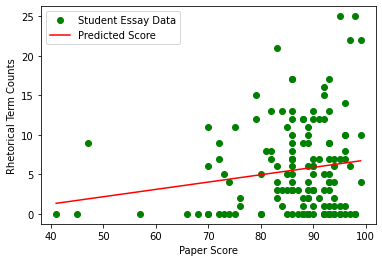

R-squared for Rhetorical Terms: 0.02503008582689576


In [108]:
#Check if amount of all term usage is indicative of grade
#Based on results, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)

#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Sum_Terms'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)

plt.plot(x, y, 'o', label='Student Essay Data', color = 'g')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.xlabel("Paper Score")
plt.ylabel("Rhetorical Term Counts")
plt.legend()
plt.show()

print(f"R-squared for Rhetorical Terms: {result.rvalue**2:}")



R-squared for Pathos Terms: 0.030331760712749872


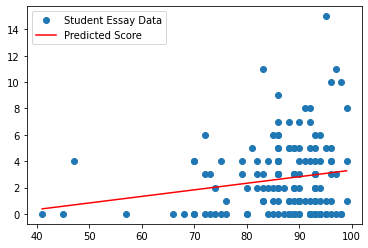

R-squared for Logos Terms: 0.014574740011472305


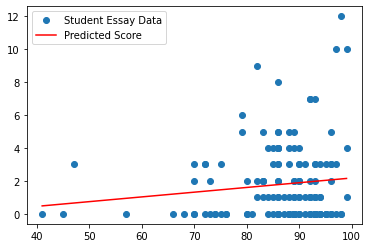

R-squared for Ethos Terms: 0.005817992471208832


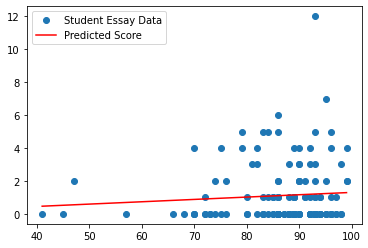

In [109]:
#Check if amount of usages of pathos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Pathos_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)

print(f"R-squared for Pathos Terms: {result.rvalue**2:}")

plt.plot(x, y, 'o', label='Student Essay Data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.legend()
plt.show()


#Check if amount of usages of logos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Logos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)

print(f"R-squared for Logos Terms: {result.rvalue**2:}")

plt.plot(x, y, 'o', label='Student Essay Data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.legend()
plt.show()


#Check if amount of usages of ethos is indicative of grade
#Create arrays of independent (x) and dependent (y) variables
x = np.array(rhetorical_keywords_df_full_texts['Portfolio_Score'])
y = np.array(rhetorical_keywords_df_full_texts['Ethos_Counts'])


#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)

print(f"R-squared for Ethos Terms: {result.rvalue**2:}")

plt.plot(x, y, 'o', label='Student Essay Data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.legend()
plt.show()

In [110]:
#Plot # paragraphs in which terms were used vs. essay grade
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?

#Count number of paragraphs where terms used and append to new dataframe
new_Series = rhetorical_keywords_paragraphs_df_no_blanks['Score_ID'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3

df3.rename(columns={"index": "Score_ID", "Score_ID": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.Score_ID.str.split(", ",expand=True)

df3

#Plot paragraph counts per paper
fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["Score_ID"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(title_text='Number of Paragraphs Where Rhetorical Terms Were Used')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [111]:
df3[['Score','ID']] = df3.Score_ID.str.split(", ",expand=True)
df3['Score'] = df3['Score'].map(lambda x: x.lstrip('Score: '))
df3 = df3[['Score','Paragraph_Counts']].copy()
df3 = df3.apply(pd.to_numeric)
df3

,Score,Paragraph_Counts
0,92.0,1
1,91.0,1
2,93.0,1
3,84.0,1
4,85.0,1
...,...,...
102,86.0,8
103,98.0,8
104,97.0,9
105,99.0,9


R-squared for Terms Per Paragraph: 0.016040691362699224


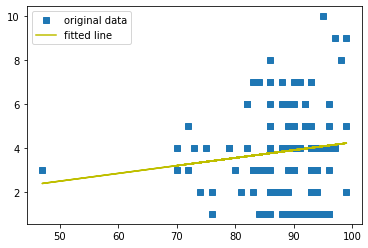

In [113]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms per paragraph is indicative of grade
#Create arrays of independent (x) and dependent (y) variables


x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)

print(f"R-squared for Terms Per Paragraph: {result.rvalue**2:}")

plt.plot(x, y, 's', label='original data')
plt.plot(x, result.intercept + result.slope*x, 'y', label='fitted line')
plt.legend()
plt.show()

### Citation Practice Regression Analysis


In [114]:
#Using FULL TEXTS Get any text inside parentheticals and count of parentheticals and append to dataframe
#https://stackoverflow.com/questions/24696715/regex-for-match-parentheses-in-python
parentheticals = r'(?<=\().*?(?=\))'

parenthetical_matches = []
parenthetical_counts = []

citation_df_full_texts = clean_essay_grades_df[['ID', 'Section', 'Portfolio_Score','Text']].copy()
for text in citation_df_full_texts['Text']:
  matches = re.findall(parentheticals, text)
  parenthetical_matches.append(matches)
  parenthetical_counts.append(len(matches))

citation_df_full_texts["Parentheticals"] = parenthetical_matches
citation_df_full_texts['Parenthetical_Counts'] = parenthetical_counts
citation_df_full_texts

,ID,Section,Portfolio_Score,Text,Parentheticals,Parenthetical_Counts
139,185594,Section: 039,41.0,Vivek Chowdary Kotapati 12/07/2020. Dear Port...,[ So the bees could haul its honey back inside],1
135,151066,Section: 039,45.0,Temple University Final Writing Portfolio Emme...,"[p. 46, 44, p.42, 45, 53, 54, 48, 48, 48, 48, ...",41
138,195858,Section: 039,47.0,"Sophie Jung December 7, 2020 SaraGrace Stefan...","[39, “Why Stopping Street Harassment Matters”,...",23
129,192375,Section: 039,57.0,Olivia Davino Professor SaraGrace Stefan Analy...,"[Orso, Orso, Orso, Orso, Orso, Orso, now-mayor...",15
73,199773,Section: 011,66.0,Liam A. Hart Megan Kane Analytical Reading and...,"[Orso, A, Orso, A, either in the moment or lat...",18
...,...,...,...,...,...,...
13,156676,Section: 010,98.0,Noah Palmer Professor Megan Kane ENG 082 4 Dec...,"[Computer Science, “Some Thoughts On Mercy”, G...",37
37,194101,Section: 010,98.0,"Paul Kushnirsky Professor Stefan English 0802,...","[Knowles and Bellware, Knowles and Bellware, K...",37
27,191777,Section: 010,99.0,Olivia Blake Professor SaraGrace Stefan ENG 08...,[mainly clarifying and expanding upon my comme...,52
36,190309,Section: 010,99.0,Emma Jensen Professor SaraGrace Stefan Analyti...,"[Brown University, Brown University, Brown Uni...",32


In [115]:
#Add ID and score in one column
citation_df_full_texts['Score_ID'] = 'Score: ' + citation_df_full_texts['Portfolio_Score'].astype(str) + ', ID:' + citation_df_full_texts['ID'].astype(str)

In [116]:
#Chart number of times parentheticals were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Parenthetical_Tags', x=citation_df_full_texts["Score_ID"], y=citation_df_full_texts["Parenthetical_Counts"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of Parentheticals Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

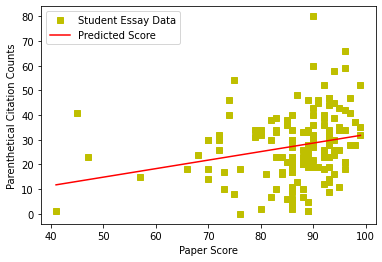

R-squared for Parenthetical Citations: 0.057408439670525085


In [117]:
#Regression: Parentheticals vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(citation_df_full_texts['Portfolio_Score'])
y = np.array(citation_df_full_texts['Parenthetical_Counts'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)


plt.plot(x, y, 's', label='Student Essay Data', color = 'y')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.xlabel("Paper Score")
plt.ylabel("Parenthetical Citation Counts")
plt.legend()
plt.show()

print(f"R-squared for Parenthetical Citations: {result.rvalue**2:}")



In [118]:
#Plot # paragraphs in which terms were used vs. essay grade
##In other words, do more successful writers use terms in multiple paragrpahs (indicating more coherence)?

#Count number of paragraphs where terms used and append to new dataframe
new_Series = citation_df['Score_ID'].value_counts(ascending=True)
df3 = pd.DataFrame(new_Series).reset_index()
df3

df3.rename(columns={"index": "Score_ID", "Score_ID": "Paragraph_Counts"}, errors="raise", inplace=True)
df3[['ID','Score']] = df3.Score_ID.str.split(", ",expand=True)

df3

#Plot paragraph counts per paper
fig = go.Figure(data=[
    go.Bar(name='Paragraph Counts', x=df3["Score_ID"], y=df3["Paragraph_Counts"]),

])
# Change the bar mode
fig.update_layout(title_text='Number of Paragraphs Where Citation Terms Were Used')
fig.update_layout(barmode='stack', xaxis={'categoryorder':'category ascending'})
fig.show()

In [119]:
df3[['Score','ID']] = df3.Score_ID.str.split(", ",expand=True)
df3['Score'] = df3['Score'].map(lambda x: x.lstrip('Score: '))
df3 = df3[['Score','Paragraph_Counts']].copy()
df3 = df3.apply(pd.to_numeric)
df3

,Score,Paragraph_Counts
0,89.0,7
1,41.0,16
2,93.0,16
3,81.0,18
4,86.0,19
...,...,...
142,90.0,70
143,86.0,101
144,96.0,111
145,92.0,120


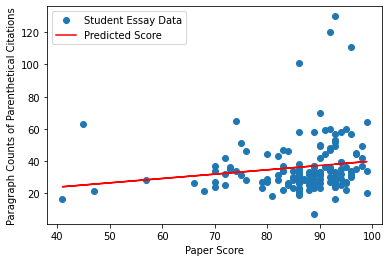

R-squared for Parenthetical Citations Per Paragraph: 0.022716778762463533


In [120]:
#Check if amount of paragraph term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats

#Check if amount of usages of all terms per paragraph is indicative of grade
#Create arrays of independent (x) and dependent (y) variables


x = np.array(df3['Score'])
y = np.array(df3['Paragraph_Counts'])

#Return key values of linear regressionslope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)


plt.plot(x, y, 'o', label='Student Essay Data')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.xlabel("Paper Score")
plt.ylabel("Paragraph Counts of Parenthetical Citations")
plt.legend()
plt.show()

print(f"R-squared for Parenthetical Citations Per Paragraph: {result.rvalue**2:}")


The analysis below uses output from the DocuScope Corpus Analysis platform. This platform is freely available for download from Carnegie Melon University:https://www.cmu.edu/dietrich/english/research-and-publications/docuscope.html
 

DocuScope is a dictionary-based tool that "tags" words and phrases in texts based on its 50+ categories of rhetorical primers. The tool might tag the words “according to,” and “is proposing that” as evidence that the student is engaging in citation, for example. In aggregate, these counts can indicate to what degree each text in a corpus contains language indicating a particular rhetorical effect. Our interest in this case is the language DocuScope has tagged as indicating "Citation" is occuring; this language can be isolated from the CSV generated from the DocuScope tool, and an example can be found on this Github repository. 

In [90]:
##Let's do the same using DocuScope citation data
#Upload csv with LAT data
uploaded_LATS = files.upload()

Saving DIMENSION_C_deidentified_texts_citation_clusters.csv to DIMENSION_C_deidentified_texts_citation_clusters.csv


In [121]:
lats_df = pd.read_csv('DIMENSION_C_deidentified_texts_citation_clusters.csv')
lats_df

,Filename,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation
0,117922.txt,19,9,34,0,0,31,0,0,93
1,142981.txt,7,7,34,0,0,17,0,0,65
2,151066.txt,15,24,46,0,0,13,0,0,98
3,153053.txt,2,0,0,0,0,1,0,0,3
4,153690.txt,14,5,21,1,0,38,1,0,80
...,...,...,...,...,...,...,...,...,...,...
142,233133.txt,11,2,25,0,0,27,0,0,65
143,233386.txt,8,6,15,1,0,27,0,0,57
144,233407.txt,5,6,21,0,0,19,0,0,51
145,237430.txt,21,0,9,0,0,19,0,0,49


In [122]:
#Make ID document to merge docuscope lats with
ids = clean_essay_grades_df[['ID', 'Portfolio_Score']].copy()
ids

#Rename filename column to id and merge target and LAT tables based on ID
lats_df.rename(columns={"Filename": "ID"}, inplace=True)
lats_df['ID'] = lats_df['ID'].map(lambda x: x.rstrip('.txt'))
lats_df['ID'] = lats_df['ID'].astype('float')
merged_lat_df = pd.merge(ids, lats_df, on='ID')

#Add ID and score in one column
merged_lat_df['Score_ID'] = 'Score: ' + merged_lat_df['Portfolio_Score'].astype(str) + ', ID:' + merged_lat_df['ID'].astype(str)
merged_lat_df

,ID,Portfolio_Score,CitationAuthority,CitationControversy,CitationGeneric,CitationHedged,CitationNegative,CitationNeutral,CitationSpeakerLookMood,UncertainCitation,Citation,Score_ID
0,185594,41.0,0,1,7,0,0,23,0,0,31,"Score: 41.0, ID:185594"
1,151066,45.0,15,24,46,0,0,13,0,0,98,"Score: 45.0, ID:151066"
2,195858,47.0,1,1,19,0,0,15,0,0,36,"Score: 47.0, ID:195858"
3,192375,57.0,11,4,19,0,0,11,0,0,45,"Score: 57.0, ID:192375"
4,199773,66.0,7,0,27,0,0,11,0,0,45,"Score: 66.0, ID:199773"
...,...,...,...,...,...,...,...,...,...,...,...,...
142,156676,98.0,10,8,9,0,0,13,0,0,40,"Score: 98.0, ID:156676"
143,194101,98.0,26,4,37,0,0,14,0,0,81,"Score: 98.0, ID:194101"
144,191777,99.0,11,13,23,1,0,15,1,0,64,"Score: 99.0, ID:191777"
145,190309,99.0,17,6,23,0,1,22,1,0,70,"Score: 99.0, ID:190309"


In [123]:
#Chart number of times all terms were used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Citations_Tags', x=merged_lat_df["Score_ID"], y=merged_lat_df["Citation"])
])
# Change the bar mode
fig.update_layout(title_text='Counts of All Citation Cluster Terms Used in Each Essay')
fig.update_layout(barmode='stack')
fig.show()

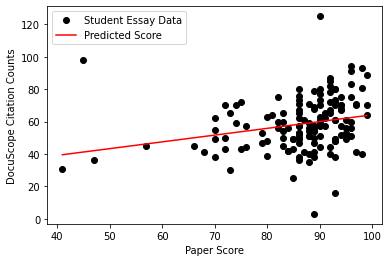

R-squared for DocuScope Citations: 0.06159044932204351


In [124]:
#Regression: Citation vs. Grade

#Check if amount of all term usage is indicative of grade
#Based on results (r = .08, there is little relationship between amount of rhetorical terms used and grade...at least between A and B range essays)
from scipy import stats


#Create arrays of independent (x) and dependent (y) variables
x = np.array(merged_lat_df['Portfolio_Score'])
y = np.array(merged_lat_df['Citation'])

#Return key values of linear regression
slope, intercept, r, p, std_err = stats.linregress(x, y)

result = stats.linregress(x, y)


plt.plot(x, y, 'o', label='Student Essay Data', color = 'k')
plt.plot(x, result.intercept + result.slope*x, 'r', label='Predicted Score')
plt.xlabel("Paper Score")
plt.ylabel("DocuScope Citation Counts")
plt.legend()
plt.show()

print(f"R-squared for DocuScope Citations: {result.rvalue**2:}")


In [125]:
#Chart number of times each citation dimension was used in each essay 
#Create bar graph
#https://plotly.com/python/bar-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='CitationAuthority', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationAuthority"]),
    go.Bar(name='CitationControversy', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationControversy"]),
    go.Bar(name='CitationGeneric', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationGeneric"]),
    go.Bar(name='CitationHedged', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationHedged"]),
    go.Bar(name='CitationNegative', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNegative"]),
    go.Bar(name='CitationNeutral', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationNeutral"]),
    go.Bar(name='CitationSpeakerLookMood', x=merged_lat_df["Score_ID"], y=merged_lat_df["CitationSpeakerLookMood"]),
    go.Bar(name='UncertainCitation', x=merged_lat_df["Score_ID"], y=merged_lat_df["UncertainCitation"]),

])


# Change the bar mode
fig.update_layout(title_text='Counts of Each Rhetorical Term in Each Essay')
fig.update_layout(barmode='stack')
fig.show()